# 1.	Gerekli Kütüphanelerin Yüklenmesi

In [21]:
import os
import random
import shutil
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 2.	Veri Seti Yükleme

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Maskeli görüntü sayısı: 3725
Masksiz görüntü sayısı: 3828


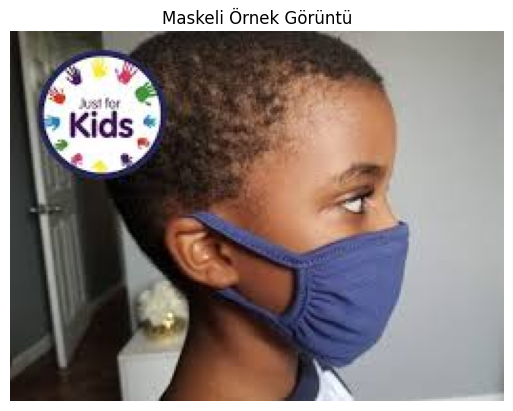

In [22]:
from google.colab import drive
drive.mount('/content/drive')

# Zip dosyasının doğru yolu
zip_path = "/content/drive/MyDrive/data (1)/archive.zip"  # Google Drive'dan doğru yolu kullan

# Zip dosyasını doğru yere kopyala
!cp "$zip_path" /content/  # Dosyayı /content/ dizinine kopyala

import zipfile

# Kopyalanan dosyayı çıkart
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:  # Doğru dosya adı burada
    zip_ref.extractall("/content/face_mask_dataset")  # Çıkartma işlemi

# Veri seti dizinini belirle
dataset_dir = "/content/face_mask_dataset/data"
mask_dir = os.path.join(dataset_dir, "with_mask")
no_mask_dir = os.path.join(dataset_dir, "without_mask")

# Maskeli ve masksiz görüntü sayısını kontrol et
print(f"Maskeli görüntü sayısı: {len(os.listdir(mask_dir))}")
print(f"Masksiz görüntü sayısı: {len(os.listdir(no_mask_dir))}")

# Örnek bir görüntü gösterimi
import matplotlib.pyplot as plt
sample_image = plt.imread(os.path.join(mask_dir, os.listdir(mask_dir)[0]))
plt.imshow(sample_image)
plt.title("Maskeli Örnek Görüntü")
plt.axis('off')
plt.show()


# 3.	Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması

In [23]:
def create_pretrained_model(base_model_name, input_shape=(224, 224, 3), num_classes=2, dropout_rate=0.5):
    """
    Önceden eğitilmiş bir modelin üzerine dense ve dropout katmanları ekleyerek yeni bir model oluşturur.

    Args:
        base_model_name (str): Kullanılacak model adı ('DenseNet121' veya 'MobileNet').
        input_shape (tuple): Giriş görüntü boyutu.
        num_classes (int): Çıktı sınıf sayısı.
        dropout_rate (float): Dropout oranı.

    Returns:
        model: Eğitim için hazır Keras model nesnesi.
    """
    if base_model_name == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "MobileNet":
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Desteklenmeyen model adı. 'DenseNet121' veya 'MobileNet' seçiniz.")

    # Base modelin katmanlarını dondurma
    base_model.trainable = False

    # Yeni katmanlar ekleme
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Yeni modeli oluşturma
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# DenseNet121 Model
densenet_model = create_pretrained_model(base_model_name="DenseNet121")

# MobileNet Model
mobilenet_model = create_pretrained_model(base_model_name="MobileNet")

# Model özetlerini yazdırma
print("DenseNet121 Model Özeti:")
densenet_model.summary()

print("\nMobileNet Model Özeti:")
mobilenet_model.summary()


DenseNet121 Model Özeti:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,427,650 (28.33 MB)

 Trainable params: 390,146 (1.49 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


MobileNet Model Özeti:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,619,010 (13.81 MB)

 Trainable params: 390,146 (1.49 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

# 4.	Veri Setinin Eğitim/Validasyon ve Test Olarak Ayrılması:
Toplam verinin %20’si test set olarak ayrılmalı, %80’i eğitim/validasyon için bırakılmalıdır.


In [24]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Dizinleri oluştur
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(train_no_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)
os.makedirs(val_no_mask_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)
os.makedirs(test_no_mask_dir, exist_ok=True)

# Maskeli ve masksiz görselleri al
mask_images = os.listdir(mask_dir)
no_mask_images = os.listdir(no_mask_dir)

# Eğitim, validasyon ve test setlerini ayırma
train_mask, temp_mask = train_test_split(mask_images, test_size=0.4, random_state=42)
train_no_mask, temp_no_mask = train_test_split(no_mask_images, test_size=0.4, random_state=42)

val_mask, test_mask = train_test_split(temp_mask, test_size=0.5, random_state=42)
val_no_mask, test_no_mask = train_test_split(temp_no_mask, test_size=0.5, random_state=42)

# Eğitim ve validasyon setlerine kopyala
for image in train_mask:
    shutil.copy(os.path.join(mask_dir, image), os.path.join(train_mask_dir, image))
for image in val_mask:
    shutil.copy(os.path.join(mask_dir, image), os.path.join(val_mask_dir, image))
for image in test_mask:
    shutil.copy(os.path.join(mask_dir, image), os.path.join(test_mask_dir, image))

for image in train_no_mask:
    shutil.copy(os.path.join(no_mask_dir, image), os.path.join(train_no_mask_dir, image))
for image in val_no_mask:
    shutil.copy(os.path.join(no_mask_dir, image), os.path.join(val_no_mask_dir, image))
for image in test_no_mask:
    shutil.copy(os.path.join(no_mask_dir, image), os.path.join(test_no_mask_dir, image))

# Dosya sayısını yazdırma
print(f"Maskeli görüntü sayısı (train): {len(os.listdir(train_mask_dir))}")
print(f"Masksiz görüntü sayısı (train): {len(os.listdir(train_no_mask_dir))}")
print(f"Maskeli görüntü sayısı (validation): {len(os.listdir(val_mask_dir))}")
print(f"Masksiz görüntü sayısı (validation): {len(os.listdir(val_no_mask_dir))}")
print(f"Maskeli görüntü sayısı (test): {len(os.listdir(test_mask_dir))}")
print(f"Masksiz görüntü sayısı (test): {len(os.listdir(test_no_mask_dir))}")



Maskeli görüntü sayısı (train): 2980
Masksiz görüntü sayısı (train): 3062
Maskeli görüntü sayısı (validation): 1124
Masksiz görüntü sayısı (validation): 1158
Maskeli görüntü sayısı (test): 745
Masksiz görüntü sayısı (test): 766


# 5.	Eğitim/Validasyon Setinin Bölünmesi ve Modelin Eğitilmesi
Daha önce ayırdığınız eğitim+validasyon verisini %80’i eğitim %20’si validasyon olarak rastgele bölün. Eğitim verisine  veri arttırımı uygulayın


In [25]:
# Veri arttırımı için ImageDataGenerator ayarları
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasyon ve test için sadece rescale işlemi
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Eğitim verilerini al
train_generator = train_datagen.flow_from_directory(
    "/content/face_mask_dataset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Çünkü iki sınıfımız var: Maskeli ve masksiz
)

# Validasyon verilerini al
val_generator = val_test_datagen.flow_from_directory(
    "/content/face_mask_dataset/validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test verilerini al
test_generator = val_test_datagen.flow_from_directory(
    "/content/face_mask_dataset/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6042 images belonging to 2 classes.
Found 2282 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


# Model

DenseNet121 Model Eğitiliyor...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/189 ━━━━━━━━━━━━━━━━━━━━ 42s 555ms/step - accuracy: 0.8199 - loss: 0.3542

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 153s 628ms/step - accuracy: 0.8606 - loss: 0.2869 - val_accuracy: 0.9864 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 86s 444ms/step - accuracy: 0.9711 - loss: 0.0910 - val_accuracy: 0.9934 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 447ms/step - accuracy: 0.9696 - loss: 0.0877 - val_accuracy: 0.9956 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 141s 442ms/step - accuracy: 0.9749 - loss: 0.0858 - val_accuracy: 0.9899 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 448ms/step - accuracy: 0.9742 - loss: 0.0773 - val_accuracy: 0.9965 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 86s 445ms/step - accuracy: 0.9756 - loss: 0.0714 - val_accuracy: 0.9908 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 86s 443ms/step - accuracy: 0.9768

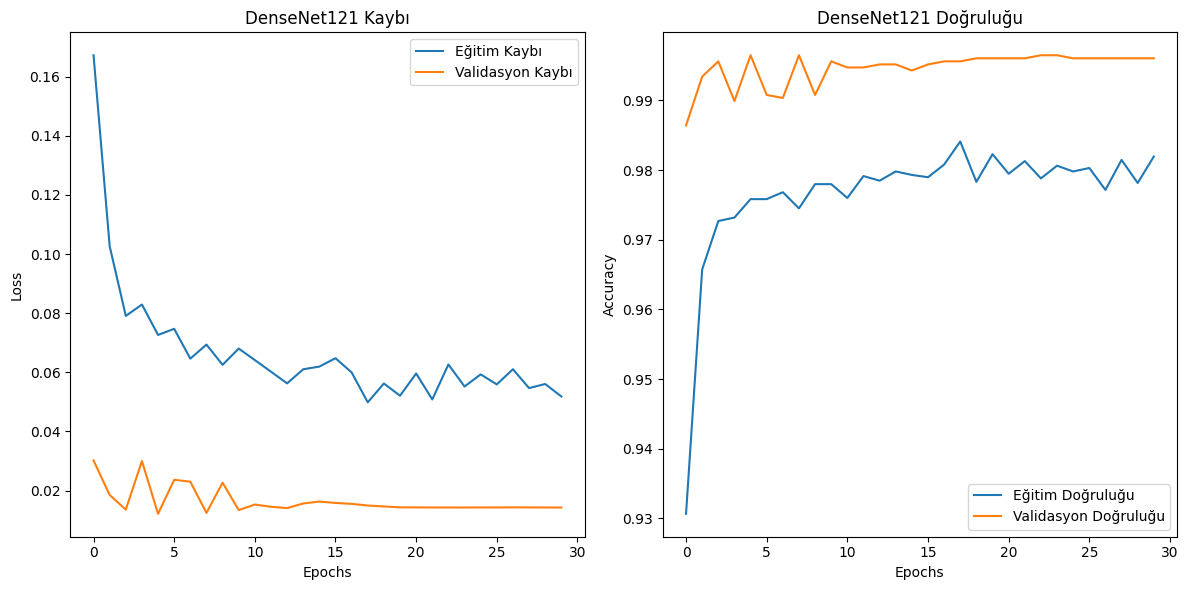

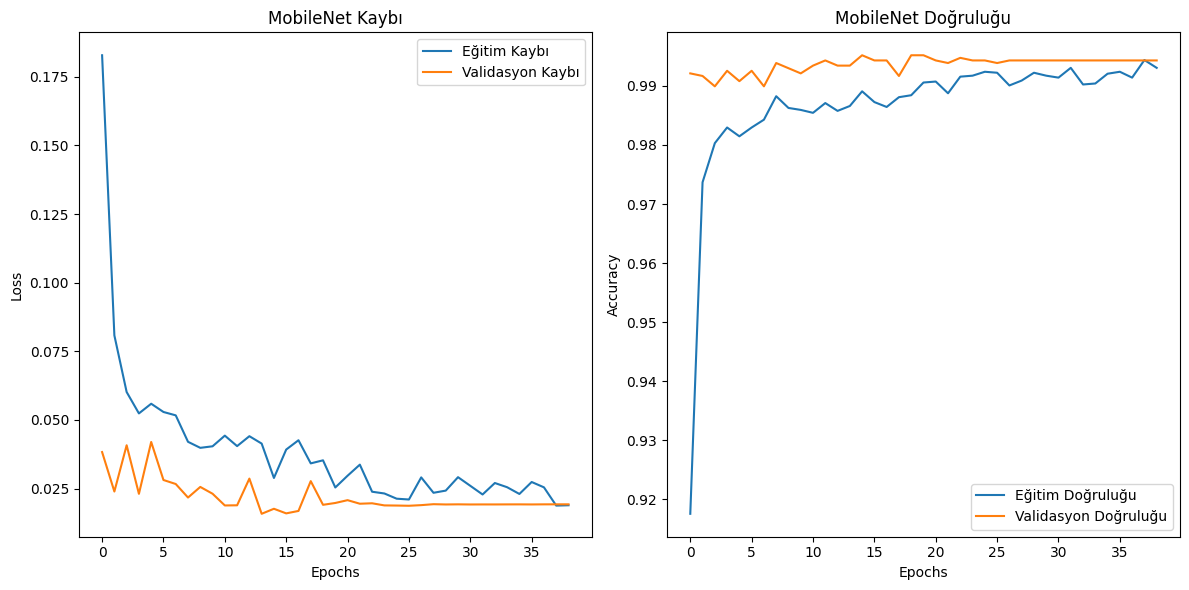

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
# Modeli derlemek
def compile_and_train(model, train_generator, val_generator, epochs=100, initial_lr=0.001):
    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    # Adam optimizer
    optimizer = Adam(learning_rate=initial_lr)

    # Modeli derle
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Eğitim sürecini başlat
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

# Model özetlerini yazdırma
densenet_model = create_pretrained_model(base_model_name="DenseNet121")
mobilenet_model = create_pretrained_model(base_model_name="MobileNet")

# DenseNet121 Modeli Eğit
print("DenseNet121 Model Eğitiliyor...")
densenet_history = compile_and_train(densenet_model, train_generator, val_generator)

# MobileNet Modeli Eğit
print("\nMobileNet Model Eğitiliyor...")
mobilenet_history = compile_and_train(mobilenet_model, train_generator, val_generator)

# Eğitim ve Validasyon Kaybı ve Doğruluğunu Çizdirmek
def plot_history(history, model_name):
    # Eğitim ve Validasyon Kayıplarını çiz
    plt.figure(figsize=(12, 6))

    # Kaybı çiz
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Validasyon Kaybı')
    plt.title(f'{model_name} Kaybı')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluğu çiz
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Validasyon Doğruluğu')
    plt.title(f'{model_name} Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Her modelin eğitim ve doğruluk grafiğini çiz
plot_history(densenet_history, "DenseNet121")
plot_history(mobilenet_history, "MobileNet")

# Yorum

**DenseNet**

Eğitim ilk epoch'larda hızlı şekilde doğruluk oranı olarak yüzde 97'ye kadar yükseliyor. Epoch sayısı arttıkça loss grafiğinde de düşüş gözlemleniyor.

ReduceLROnPlateau callback fonksiyonu ise accuracy'nin fazla olduğu yerde öğrenme oranını düşürüyor ve optimal noktayı bulmaya çalışıyor. Model en son epochlarda öğrenme oranını çok düşük seviyey indirdi.

Modelin doğruluk seviyesinde önemli artış yaşanmadığı için early stopping fonksiyonu ile daha fazla eğitilmedi. Gereksiz yere eğitmemiş olduk. 30. epoch'tan sonra model eğitimi bıraktı.

Accuracy: 98.31

Validation Accuracy: 99.61

Accuracy değerlerine bakarsak modelimiz iyi sınıflandırıyor. Overfitting gözükmüyor, validasyon loss değeri düşük.
Validasyon performansı eğitim performansından iyi olduğu için genelleme yeteneği iyi.


**MobileNet**

Model ilk epoch'ta %81 accuracy ile başlayıp ikinci epoch'ta %97 accuracy'e sıçramış ve hızla öğrenmiştir.

Loss değeri 0.02 seviyelerine kadar düşmüştür.

Başlangıçta learning rate 0.001 iken 20. epoch'ta 0.0001, 25. epochta 0.00001, 30. epoch'ta 0.000001'e kadar düştü. Yani adoğruluk arttıkça öğrenme katsayımızı düşürdük ReduceLRonPlateu ile.

Validasyon ve eğitim eğrileri birbirini yakınlar overfitting olmadığını görebiliyoruz. Genelleme performansımız çok iyi.

EarlyStopping parametresi 39. epoch'ta durdu daha fazla eğitime gerek yok, modelimiz optimum noktaya ulaştı.




# 4.Test Verisi İle Tahmin (Prediction) ve Sonuç Analizi

In [28]:
# Modeli kaydetmek için
densenet_model.save('densenet_model.h5')  # DenseNet121 modelini kaydediyoruz
mobilenet_model.save('mobilenet_model.h5')  # MobileNet modelini kaydediyoruz


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 333ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step


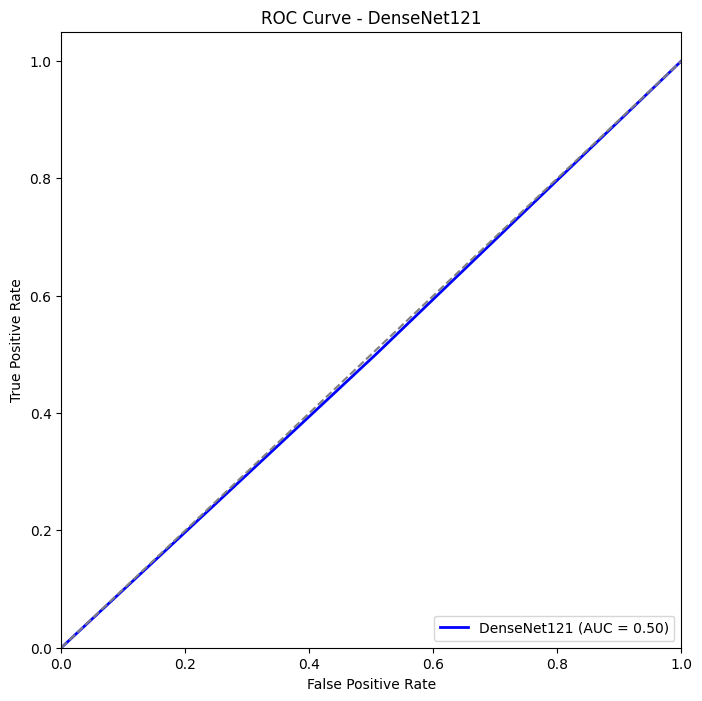

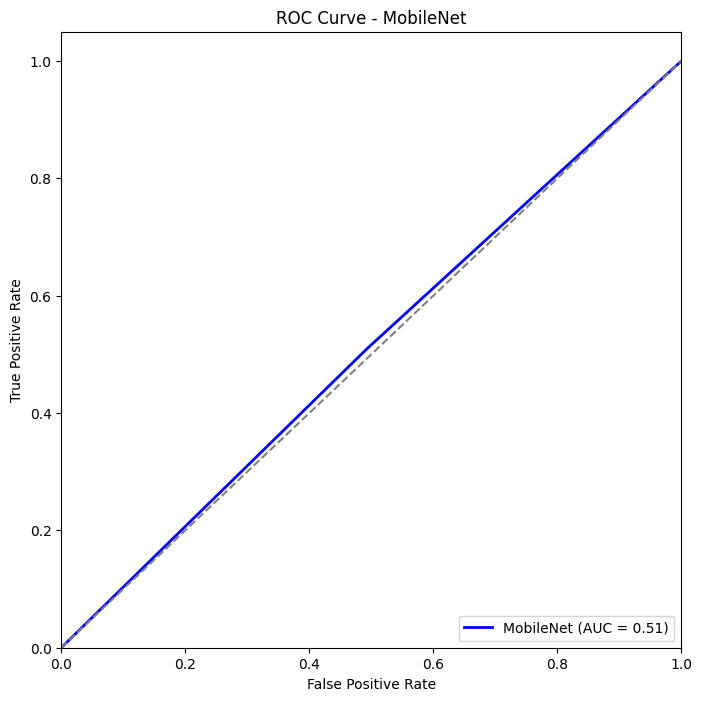

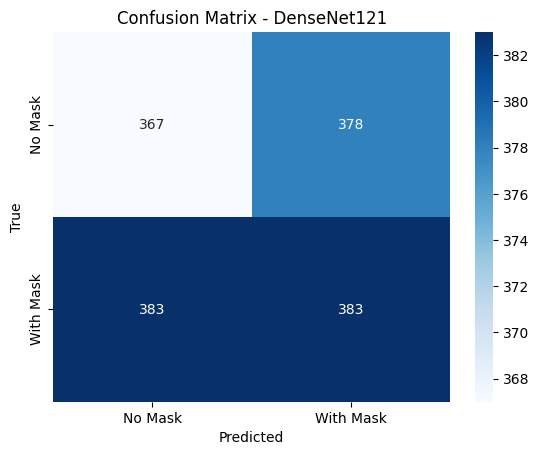

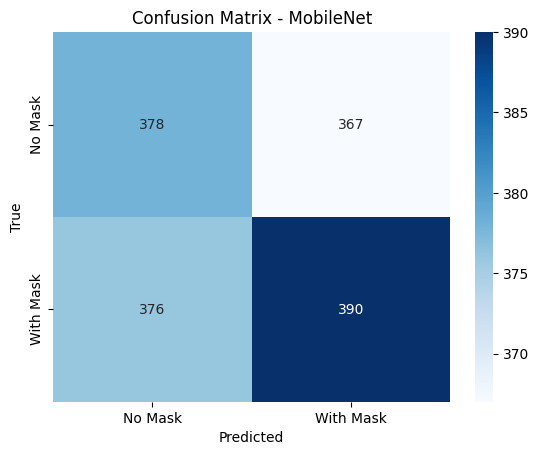

DenseNet121 Classification Report:
              precision    recall  f1-score   support

     No Mask       0.49      0.49      0.49       745
   With Mask       0.50      0.50      0.50       766

    accuracy                           0.50      1511
   macro avg       0.50      0.50      0.50      1511
weighted avg       0.50      0.50      0.50      1511


MobileNet Classification Report:
              precision    recall  f1-score   support

     No Mask       0.50      0.51      0.50       745
   With Mask       0.52      0.51      0.51       766

    accuracy                           0.51      1511
   macro avg       0.51      0.51      0.51      1511
weighted avg       0.51      0.51      0.51      1511


DenseNet121 Metrics:
Accuracy: 0.50
Precision: 0.50
Recall: 0.50
Specificity: 0.49
F1-Score: 0.50

MobileNet Metrics:
Accuracy: 0.51
Precision: 0.52
Recall: 0.51
Specificity: 0.51
F1-Score: 0.51


In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Kaydedilen modelin yüklenmesi
densenet_model = load_model('densenet_model.h5')
mobilenet_model = load_model('mobilenet_model.h5')

# Test verisini hazırlama (Örnek olarak test_generator kullanılıyor)
# test_generator = ...

# Test seti üzerinde tahmin yapma
y_pred_densenet = densenet_model.predict(test_generator, verbose=1)
y_pred_mobilenet = mobilenet_model.predict(test_generator, verbose=1)

# Gerçek etiketler
y_true = test_generator.classes

# En yüksek olasılık değerine göre tahmin yapma (y_pred'in argmax'ını alacağız)
y_pred_densenet = np.argmax(y_pred_densenet, axis=1)
y_pred_mobilenet = np.argmax(y_pred_mobilenet, axis=1)

# ROC Eğrisi ve AUC (DenseNet ve MobileNet için ayrı ayrı)
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_true, y_pred_densenet, 'DenseNet121')
plot_roc_curve(y_true, y_pred_mobilenet, 'MobileNet')

# Confusion Matrix (Karışıklık Matrisi)
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'With Mask'], yticklabels=['No Mask', 'With Mask'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred_densenet, 'DenseNet121')
plot_confusion_matrix(y_true, y_pred_mobilenet, 'MobileNet')

# Classification Report (Precision, Recall, F1-score)
report_densenet = classification_report(y_true, y_pred_densenet, target_names=['No Mask', 'With Mask'])
report_mobilenet = classification_report(y_true, y_pred_mobilenet, target_names=['No Mask', 'With Mask'])

print("DenseNet121 Classification Report:")
print(report_densenet)

print("\nMobileNet Classification Report:")
print(report_mobilenet)

# Accuracy, Precision, Recall, Specificity, F1-Score (Kendi hesaplamalarımız)
def calculate_metrics(cm):
    accuracy = np.trace(cm) / float(np.sum(cm))
    precision = cm[1, 1] / float(cm[0, 1] + cm[1, 1])
    recall = cm[1, 1] / float(cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / float(cm[0, 0] + cm[0, 1])
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, specificity, f1_score

cm_densenet = confusion_matrix(y_true, y_pred_densenet)
cm_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)

metrics_densenet = calculate_metrics(cm_densenet)
metrics_mobilenet = calculate_metrics(cm_mobilenet)

print("\nDenseNet121 Metrics:")
print(f"Accuracy: {metrics_densenet[0]:.2f}")
print(f"Precision: {metrics_densenet[1]:.2f}")
print(f"Recall: {metrics_densenet[2]:.2f}")
print(f"Specificity: {metrics_densenet[3]:.2f}")
print(f"F1-Score: {metrics_densenet[4]:.2f}")

print("\nMobileNet Metrics:")
print(f"Accuracy: {metrics_mobilenet[0]:.2f}")
print(f"Precision: {metrics_mobilenet[1]:.2f}")
print(f"Recall: {metrics_mobilenet[2]:.2f}")
print(f"Specificity: {metrics_mobilenet[3]:.2f}")
print(f"F1-Score: {metrics_mobilenet[4]:.2f}")


Recall: İki modeli kıyasladığımızda pozitifleri daha iyi yakalama konusunda MobileNet önde.

F1-Score: Dengeli performans metriğine bakarsak 0.01 fark ile MobileNet önde.

MobileNet modeli DenseNet modelini burun farkıyla geçiyor. Test veri setinde modellerimiz iyi başarı göstermiyor.  Veri seti arttırılabilir, data augmentation teknikleri uygulanabilir. Modelin hiperparametreleri için optimizasyon yapılabilir.

Eğitim sırasında %99 doğruluk elde edilmesine rağmen test setinde %50-51 performans, aşırı öğrenme (overfitting) olduğunu gösterir bize.

Eğitim ve test veri seti seti arasında dağılım farkı olabilir.
Veri seti dengesiz dağılmış olabilir.

Model iyileştirmesi için dropout ekleyebiliriz.